# Assignment 2: Transformations & Filtering (20 Pts)

In this homework, we will explore some of the geometry that underlies how camera images are formed and how image filtering works.

## Conda Setup

Generate the conda environment by running in the terminal:

`conda create --name gcv_exercise_2 python=3.11`

Run to activate environment:

`conda activate gcv_exercise_2`

Install all required packages for this exercise by running:

`conda install matplotlib numpy scikit-image scikit-learn`

Install OpenCV

`conda install -c conda-forge opencv`

Install Jupyter Notebook requirements:

`conda install -n gcv_exercise_2 ipykernel --update-deps --force-reinstall`

(Optional) If you are working on the TUWEL Juypter Notebooks:

`ipython kernel install --name "GCV_E_2" --user`

## Notebook Setup & Imports

In [26]:
# Setup

# Numpy is the main package for scientific computing with Python. 
# This will be one of our most used libraries in this class
import numpy as np

# The Time library helps us time code runtimes
from time import time

# Import the Scikit-Image library
from skimage import io
from sklearn.neighbors import NearestNeighbors

# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def hash_numpy(x):
    import hashlib

    return hashlib.sha1(x.view(np.uint8)).hexdigest()

## Part 1: Transformations in 3D

In order to make sense of how objects in our world are rendered in a camera, we typically need to understand how they are located relative to the camera. In this question, we'll examine some properties of the transformations that formalize this process by expressing coordinates with respect to multiple frames. 

We'll be considering a scene with two frames: a world frame ($W$) and a camera frame ($C$).

Notice that:
- We have 3D points $p$, $q$, $r$, and $s$ that define a square, which is parallel to the world $zy$ plane
- $C_z$ and $C_x$ belong to the plane defined by $W_z$ and $W_x$
- $C_y$ is parallel to $W_y$

<!-- into camera space as we translate a simple shape from world coordinates to camera coordinates. We will take this square in world coordinates and transform it into the camera coordinates.-->

<img src="imgs/projection_geometry.png" alt="projection geometry figure" width="640" />

### Question 1.1: Reference Frame Definitions (3 Pts)

First, we'll take a moment to validate your understanding of 3D reference frames.

Consider creating:
- A point $w$ at the origin of the world frame ($O_w$)
- A point $c$ at the origin of the camera frame ($O_c$)

Examine the $x$, $y$, and $z$ axes of each frame, then express these points with respect to the world and camera frames. Fill in **`w_wrt_camera`**, **`c_wrt_world`**, and **`c_wrt_camera`**.

You can consider the length $d = 1$.

In [27]:
d = 1.0

# Abbreviation note:
# - "wrt" stands for "with respect to", which is ~synonymous with "relative to"

w_wrt_world = np.array([0.0, 0.0, 0.0])  # Done for you

# *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
w_wrt_camera = np.array([0.0, 0.0, d])  # Assign me!

c_wrt_world = np.array([1.0/np.sqrt(2.0), 0.0, 1.0/np.sqrt(2.0)])# Assign me!

c_wrt_camera = np.array([0.0, 0.0, 0.0])  # Assign me!
# *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

In [28]:
# Run this cell to check your answers!
assert (
    (3,)
    == w_wrt_world.shape
    == w_wrt_camera.shape
    == c_wrt_world.shape
    == c_wrt_camera.shape
), "Wrong shape!"
assert (
    hash_numpy(w_wrt_world) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your w_wrt_world!"
assert (
    hash_numpy(w_wrt_camera) == "6248a1dcfe0c8822ba52527f68f7f98955584277"
), "Double check your w_wrt_camera!"
assert (
    hash_numpy(c_wrt_camera) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your c_wrt_camera!"
assert (
    hash_numpy(c_wrt_world) == "a4c525cd853a072d96cade8b989a9eaf1e13ed3d"
), "Double check your c_wrt_world!"

print("Looks correct!")

Looks correct!


### Question 1.2: World ⇨ Camera Transforms (3 Pts)

Derive the homogeneous transformation matrix needed to convert a point expressed with respect to the world frame $W$ in the camera frame $C$.

**Implement it in `camera_from_world_transform()`**.

We've also supplied a set of `assert` statements below to help you check your work.

---

*Hint #1:*
With rotation matrix $R \in \mathbb{R}^{3\times 3}$ and translation vector $t \in \mathbb{R}^{3\times 1}$, you can write transformations as $4 \times 4$ matrices: 
$$
\begin{bmatrix}{x_C} \\ {y_C} \\ {z_C} \\ 1\end{bmatrix} =
\begin{bmatrix}
    R & t \\
    \vec{0}^\top & 1
\end{bmatrix}
\begin{bmatrix}{x_W} \\ {y_W} \\ {z_W} \\ 1\end{bmatrix}
$$

*Hint #2: Remember our 2D transformation matrix for rotations in the $xy$ plane.*

$$
\begin{bmatrix}{x}' \\ {y}'\end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta)\end{bmatrix} \begin{bmatrix}{x} \\ {y}\end{bmatrix}
$$ 

To apply this to 3D rotations, you might think of this $xy$ plane rotation as holding the $z$ coordinate constant, since that's the axis you're rotating around, and transforming the $x$ and $y$ coordinates as described in the 2D formulation:

$$
\begin{bmatrix}{x}' \\ {y}' \\ {z}'\end{bmatrix}  = \begin{bmatrix} \cos(\theta) & -\sin(\theta) & 0 \\ \sin(\theta) & \cos(\theta) & 0 \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix}{x} \\ {y} \\ {z}\end{bmatrix}
$$

(Alternatively you could simply take the rotation matrix from the [Wikipedia](https://en.wikipedia.org/wiki/Rotation_matrix) page)

*Hint #3: In a homogeneous transform, the translation is applied after the rotation.*

As a result, you can visualize the translation as an offset in the output frame.

The order matters! You'll end up with a different transformation if you translate and then rotate versus if you rotate first and then translate with the same offsets. In the lecture we discussed a formulation for a combinated scaling, rotating, and translating matrix (in that order), which can be a useful starting point.


*Hint #4: It might be useful to look up the connection between rotations and basis transfromation matrices.*

In [ ]:
# Check your answer against 1.1!
def camera_from_world_transform(d: float = 1.0) -> np.ndarray:
    """Define a transformation matrix in homogeneous coordinates that
    transforms coordinates from world space to camera space, according
    to the coordinate systems in Question 1.
    Args:
        d (float, optional): Total distance of displacement between world and camera
,    origins. Will always be greater than or equal to zero. Defaults to 1.0.
    Returns:
        T (np.ndarray): Left-hand transformation matrix, such that c = Tw
,    for world coordinate w and camera coordinate c as column vectors.
,    Shape = (4,4) where 4 means 3D+1 for homogeneous.
    """
    T = np.eye(4)
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    # Camera origin from above (Exercise 1.1)
    c_wrt_world = np.array([d/np.sqrt(2.0), 0.0, d/np.sqrt(2.0)])

    # Rotation: around y by -135 degrees => -3*pi/4
    theta = -3.0 * np.pi / 4.0
    R = np.array([
        [ np.cos(theta), 0.0, -np.sin(theta)],
        [ 0.0,           1.0,  0.0],
        [ np.sin(theta), 0.0,  np.cos(theta)]
    ])

    # Translation must satisfy: R * c_wrt_world + t = 0  =>  t = - R * c_wrt_world
    t = - R @ c_wrt_world

    T[:3, :3] = R
    T[:3, 3]  = t
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    assert T.shape == (4, 4)
    return T

T_camera_from_world = camera_from_world_transform()

print(T_camera_from_world)

# Check c_wrt_camera against T_camera_from_world @ w_wrt_world
w_wrt_camera_computed = (T_camera_from_world @ np.append(w_wrt_world, 1.0))[:3]
print(f"w_wrt camera: expected {w_wrt_camera}, computed {w_wrt_camera_computed}")
assert np.allclose(
    w_wrt_camera, w_wrt_camera_computed
), "Error! (likely bad translation)"
print("Translation components look reasonable!")

# Check w_wrt_camera against T_camera_from_world @ c_wrt_world
c_wrt_camera_computed = (T_camera_from_world @ np.append(c_wrt_world, 1.0))[:3]
print(f"c_wrt camera: expected {c_wrt_camera}, computed {c_wrt_camera_computed}")
assert np.allclose(
    c_wrt_camera, c_wrt_camera_computed
), "Error! (likely bad rotation)"
print("Rotation component looks reasonable!")

[[-7.07106781e-01  0.00000000e+00  7.07106781e-01 -1.00875766e-16]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.07106781e-01  0.00000000e+00 -7.07106781e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
w_wrt camera: expected [0. 0. 1.], computed [-1.00875766e-16  0.00000000e+00  1.00000000e+00]
Translation components look reasonable!
c_wrt camera: expected [0. 0. 0.], computed [1.01465364e-17 0.00000000e+00 0.00000000e+00]
Rotation component looks reasonable!


## Part 2: Filtering

### Question 2.1: Convolution (2 Pts)

Recall that the convolution of an image $f:\mathbb{R}^2\rightarrow \mathbb{R}$ and a kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$ is defined as follows:
$$(f*h)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]$$

Or equivalently,
\begin{align}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align}

In this section, you will implement:
- `conv_nested`

First, run the code cell below to load the image to work with.

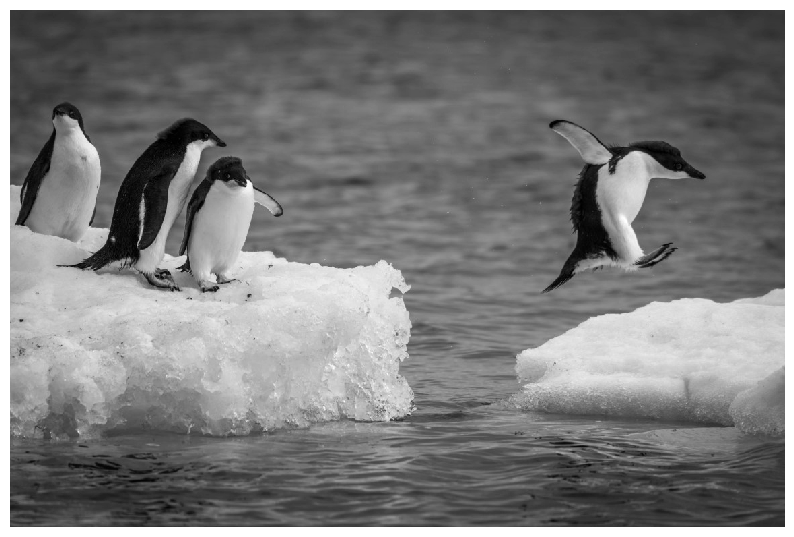

In [30]:
# Open image as grayscale
img = io.imread('imgs/penguin.jpeg', as_gray=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

Now, implement the function **`conv_nested`**. This is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $f$ and a kernel $h$ as inputs and outputs the convolved image $(f*h)$ that has the same shape as the input image. This implementation should take a few seconds to run.

*- Hint: It may be easier to implement $(h*f)$*

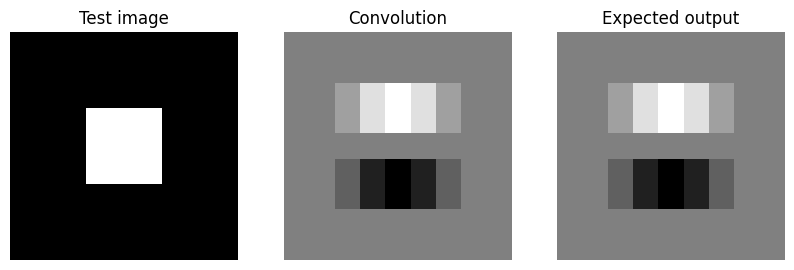

In [ ]:
def conv_nested(image, kernel):
    """A naive implementation of convolution filter.
    This is a naive implementation of convolution using 4 nested for-loops.
    This function computes convolution of an image with a kernel and outputs
    the result that has the same shape as the input image.
    HINT: Look up `np.flip()` function.
    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk). Dimensions will be odd.
    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    # Flip the kernel for convolution
    kernel_flipped = np.flip(np.flip(kernel, axis=0), axis=1)

    # Calculate padding
    pad_h = Hk // 2
    pad_w = Wk // 2

    # Pad image for boundary handling
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    
    # 4 nested loops to perform convolution
    for i in range(Hi):
        for j in range(Wi):
            for m in range(Hk):
                for n in range(Wk):
                    out[i, j] += kernel_flipped[m, n] * padded_image[i + m, j + n]
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

    return out

# Simple convolution kernel.
kernel = np.array(
[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:4, 2:3] = 1
expected_output[2:4, 6:7] = 1
expected_output[2:4, 3:4] = 3
expected_output[2:4, 5:6] = 3
expected_output[2:4, 4:5] = 4

expected_output[5:7, 2:3] = -1
expected_output[5:7, 6:7] = -1
expected_output[5:7, 3:4] = -3
expected_output[5:7, 5:6] = -3
expected_output[5:7, 4:5] = -4

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the expected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Expected output')
plt.axis('off')
plt.show()

# Test if the output matches expected output
assert np.max(test_output - expected_output) < 1e-10, "Your solution is not correct."

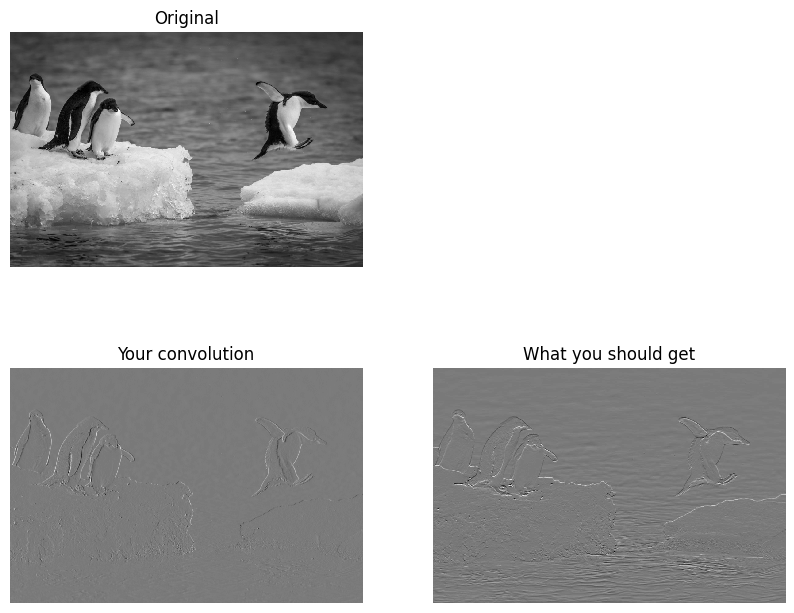

In [32]:
# Feel free to change the kernel to see different outputs.

kernel = np.array(
[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(2,2,3)
plt.imshow(out)
plt.title('Your convolution')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('imgs/convolved_penguin.jpeg')
plt.subplot(2,2,4)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

### Question 2.2 Seperable Convolution Theory (1 Pts)

Consider an $M_1\times{N_1}$ image $I$ and an $M_2\times{N_2}$ filter $F$. A filter $F$ is **separable** if it can be written as a product of two 1D filters: $F=F_1F_2$.

For example,
$$F=
\begin{bmatrix}
1 & -1 \\
1 & -1
\end{bmatrix}
$$
can be written as a matrix product of
$$F_1=
\begin{bmatrix}
1  \\
1
\end{bmatrix},
F_2=
\begin{bmatrix}
1 & -1
\end{bmatrix}
$$
Therefore $F$ is a separable filter.

Consider an $M_1\times{N_1}$ image $I$ and an $M_2\times{N_2}$ filter $F$ that is separable (i.e. $F=F_1F_2$).

(i) How many multiplication operations do you need to do a direct 2D convolution (i.e. $I*F$)?<br>
(ii) How many multiplication operations do you need to do 1D convolutions on rows and columns (i.e. $(I*F_1)*F_2$)?<br>

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

**Answer (i):** 2D Direct Convolution Number of multiplications = $M_1 \times N_1 \times M_2 \times N_2$

**Answer (ii):** 1D Convolution Number of Multiplications = $M_1 \times N_1 \times M_2 + M_1 \times N_1 \times N_2$ simplified to $M_1 \times N_1 \times (M_2 + N_2)$

Now, we will empirically compare the running time of a separable 2D convolution and its equivalent two 1D convolutions. The Gaussian kernel, widely used for blurring images, is one example of a separable filter. Run the code below to see its effect.

This took: 5.677984714508057 Seconds


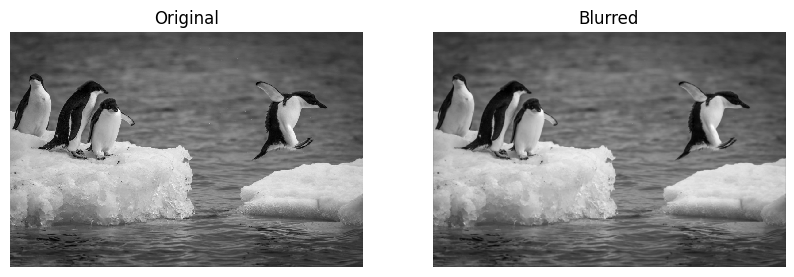

In [33]:
# 5x5 Gaussian blur
kernel = np.array([
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,36,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1]
])

t0 = time()
out = conv_nested(img, kernel)
t1 = time()
t_normal = t1 - t0

print("This took:", t_normal,"Seconds")

# Plot original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot convolved image
plt.subplot(1,2,2)
plt.imshow(out)
plt.title('Blurred')
plt.axis('off')

plt.show()

### Question 2.3 Seperable Convolution Application (2 Pts)

In the below code cell, define the two 1D arrays (`k1` and `k2`) whose product is equal to the Gaussian kernel.

In [34]:
# The kernel can be written as outer product of two 1D filters
k1 = None  # shape (5, 1)
k2 = None  # shape (1, 5)

# *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
k1 = np.array([1, 4, 6, 4, 1]).reshape(5, 1)
k2 = np.array([1, 4, 6, 4, 1]).reshape(1, 5)
# *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

# Check if kernel is product of k1 and k2
if not  np.all(k1 * k2 == kernel):
    print('k1 * k2 is not equal to kernel')
    
assert k1.shape == (5, 1), "k1 should have shape (5, 1)"
assert k2.shape == (1, 5), "k2 should have shape (1, 5)"

We now apply the two versions of convolution to the same image, and compare their running time. Note that the outputs of the two convolutions must be the same.

This took: 2.5090439319610596 Seconds


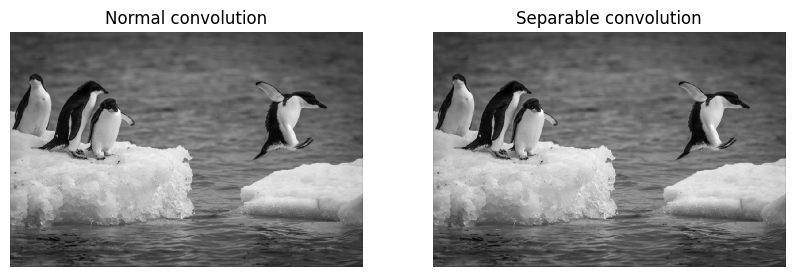

Normal convolution: took 5.677985 seconds.
Separable convolution: took 2.509044 seconds.


In [35]:
# Perform two convolutions using k1 and k2
t0 = time()
out_separable = conv_nested(img, k1)
out_separable = conv_nested(out_separable, k2)
t1 = time()
t_separable = t1 - t0

print("This took:", t_separable,"Seconds")

# Plot normal convolution image
plt.subplot(1,2,1)
plt.imshow(out)
plt.title('Normal convolution')
plt.axis('off')

# Plot separable convolution image
plt.subplot(1,2,2)
plt.imshow(out_separable)
plt.title('Separable convolution')
plt.axis('off')

plt.show()

print("Normal convolution: took %f seconds." % (t_normal))
print("Separable convolution: took %f seconds." % (t_separable))

In [36]:
# Check if the two outputs are equal
assert np.max(out_separable - out) < 1e-8

## Part 3: SIFT Descriptor

You are given a dataset called Fashion-MNIST. Fashion-MNIST is a dataset consisting of 60,000 examples of 28x28 greyscale images, associated with a label from 10 classes.

<img src="imgs/fashion-mnist.png" alt="Overview Fashion MNIST" width="960" />

We first show the matching results, just using the raw images.
The question we want to answer is: How can we improve the matching performance of the KNN-Matcher.

We have implemented a simple descriptor function for you, where each keypoint is described by the normalized intensity of a small patch around it.

### Preparing the dataset

In [11]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    #Subset of Fashion-MNIST data

    
    return images, labels

# Define the labels for each class
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train, y_train = load_mnist('data/fashion', kind='train')

### Select a subset of the data for faster runtime ###

# Set the number of objects to select per class (also defines the nearest neighbours)
k = 5

# Get the unique class labels
classes = np.unique(y_train)

# Initialize lists to store the selected features and labels
selected_X = []
selected_y = []

# For each class label, randomly select x objects
for c in classes:
    # Get the indices of the objects with class label c
    indices = np.where(y_train == c)[0]
    
    # Randomly select k objects
    selected_indices = np.random.choice(indices, size=k, replace=False)
    
    # Add the selected features and labels to the corresponding lists
    selected_X.append(X_train[selected_indices])
    selected_y.append(y_train[selected_indices])
    
# Convert the selected features and labels to numpy arrays
X_train = np.concatenate(selected_X)
y_train = np.concatenate(selected_y)

print(X_train.shape, y_train.shape)

(50, 784) (50,)


### Initial matching using the raw images

This code cell matches the images using the KNN implementation of SKLEARN, for now you do not need to understand the details about this matcher. The code plots the query image to the left (blue) and the five nearest neighbors after matching. You can run it multiple times, it always selects a new query, so results may vary. However, usually, for specific classes, the nearest neighbors are not all of the same class. Especially, the T-shirt/top and the Shirt class as well as all shoe related classes are often confused.

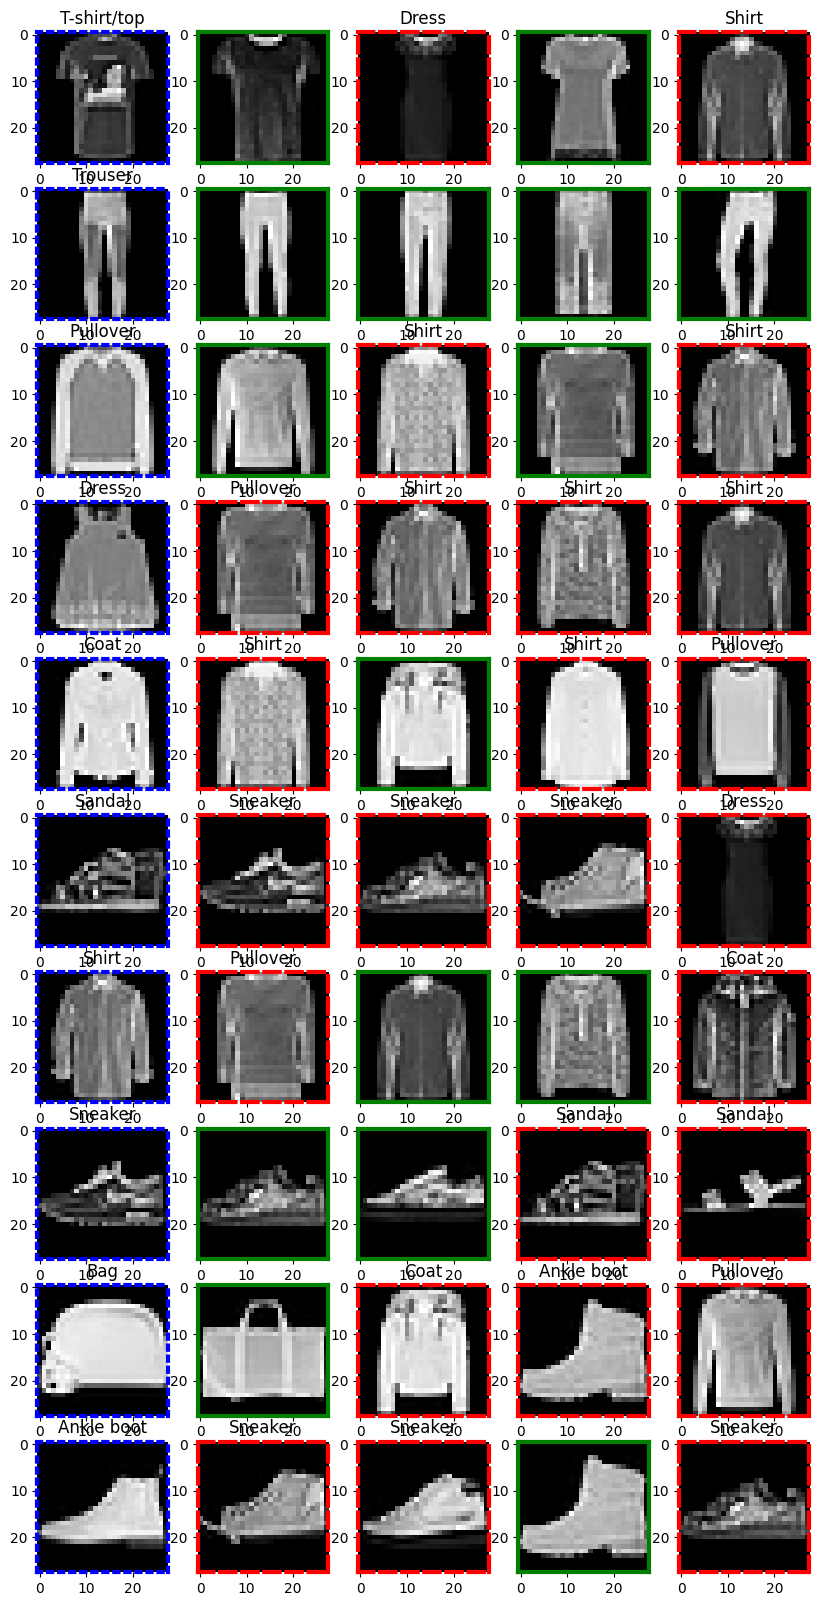

In [37]:
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_train)

# Plot the query images and their nearest neighbors
fig, axs = plt.subplots(10, k, figsize=(10, 20))
for label in range(10):
    X = X_train[y_train == label]
    idx = np.random.choice(X.shape[0], size=1, replace=False)
    query = X[idx]
    distances, indices = nbrs.kneighbors(query)

    axs[label, 0].imshow(query.reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    axs[label, 0].set_title(label_names[label])
    axs[label, 0].set_frame_on(True)
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[label, 0].spines[axis].set_linewidth(3)  # change width
        axs[label, 0].spines[axis].set_linestyle(':')
        axs[label, 0].spines[axis].set_color('blue')
        
    #axs[label, 0].axis('off')    
    for i in range(1, k):
        
        if y_train[indices[0][i]] != label:
            # If there is a false positive, mark it with a red border
            axs[label, i].imshow(X_train[indices[0][i]].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
            axs[label, i].set_frame_on(True)
            axs[label, i].set_title(label_names[y_train[indices[0][i]]])
            
            for axis in ['top', 'bottom', 'left', 'right']:
                axs[label, i].spines[axis].set_linewidth(3)  # change width
                axs[label, i].spines[axis].set_linestyle('--')
                axs[label, i].spines[axis].set_color('red')
        else:
            axs[label, i].imshow(X_train[indices[0][i]].reshape(28, 28), cmap='gray')
            axs[label, i].set_frame_on(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axs[label, i].spines[axis].set_linewidth(3)  # change width
                axs[label, i].spines[axis].set_color('green')
        #axs[label, i].axis('off')



### Complete analysis of the raw image matching

This code cell plots the overall distribution of the 6000 nearest neighbors per class. As we have 6000 samples per class in the dataset, the 6000 nearest neighbors should all be of the same class. However, as you can see this is clearly not the case.

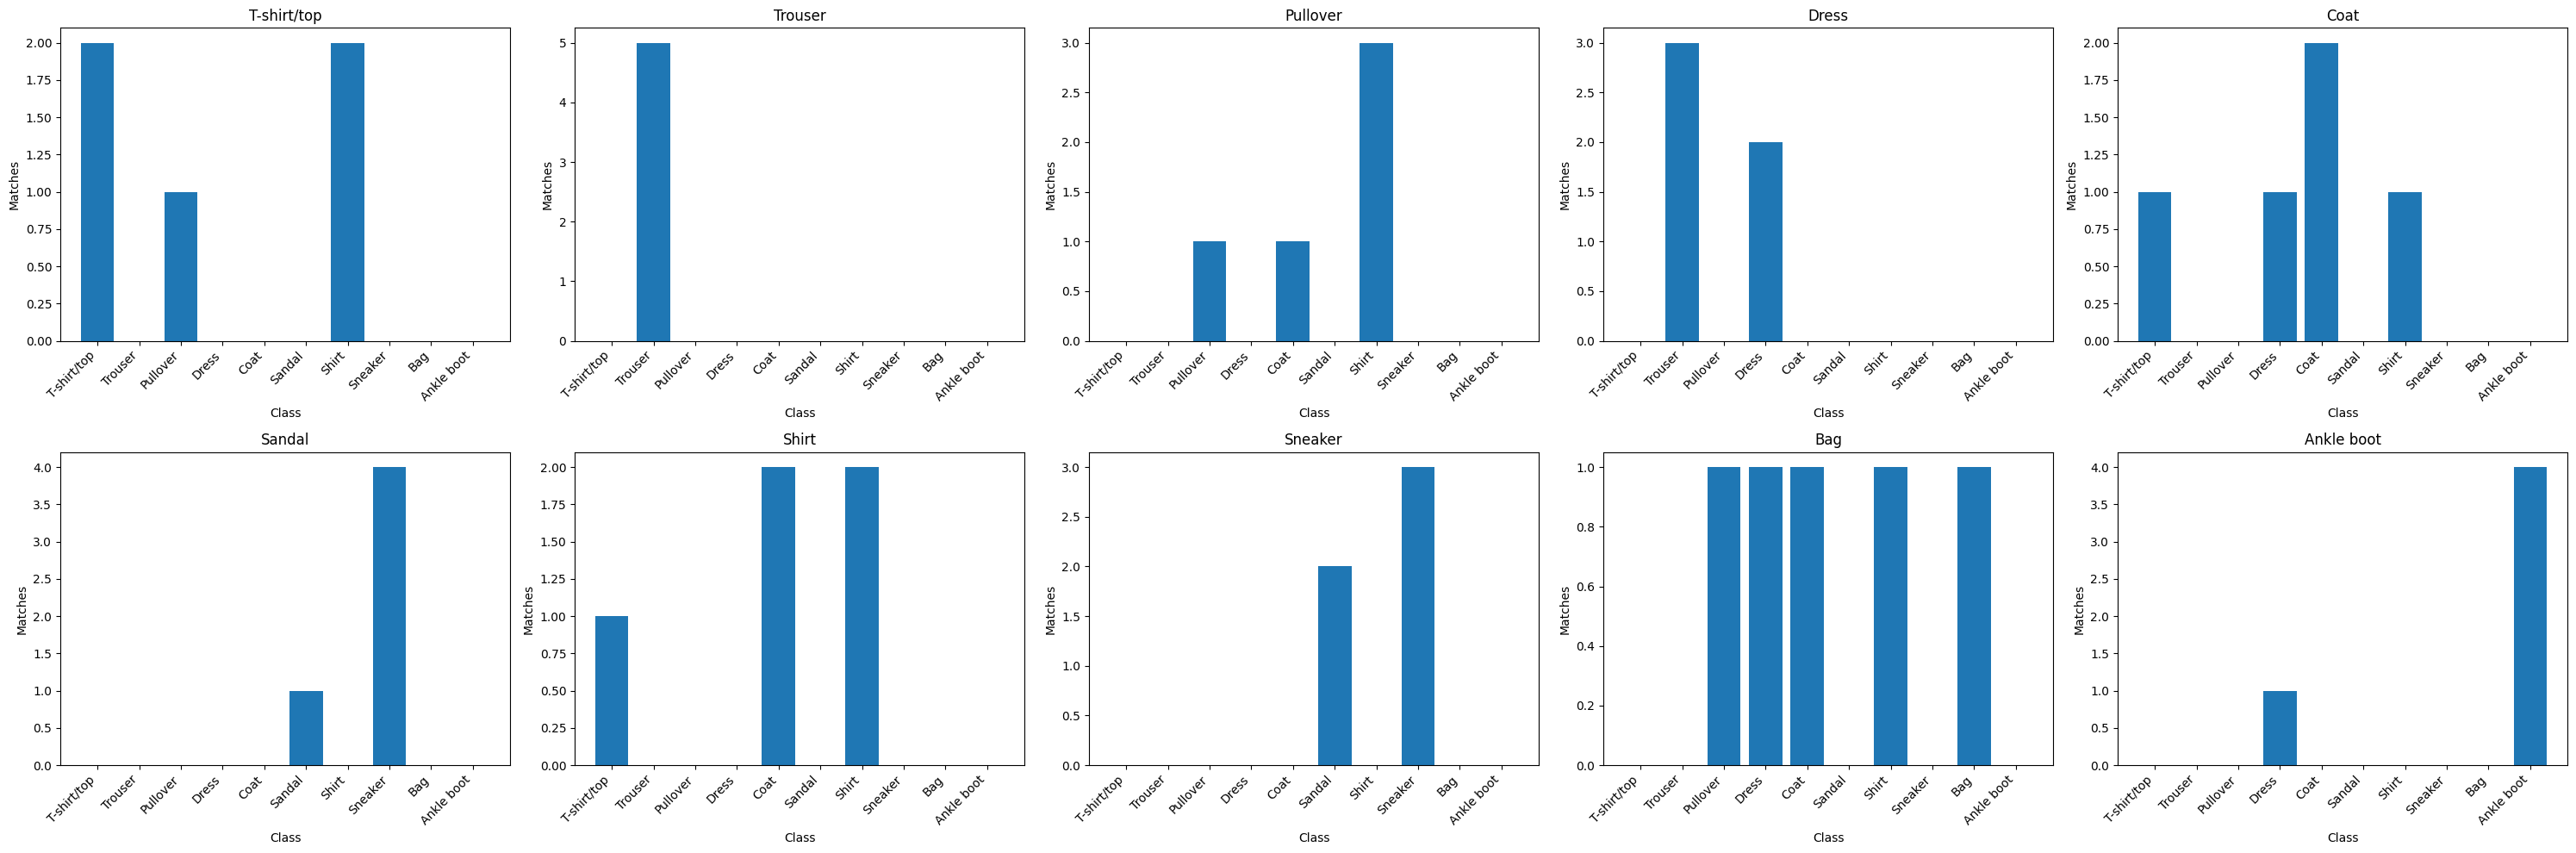

In [14]:
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_train)

fig, axs = plt.subplots(2,5, figsize=(30, 10))

axs = axs.flatten()

for label in range(10):

    X = X_train[y_train == label]
    idx = np.random.choice(X.shape[0], size=1, replace=False)
    query = X[idx]
    distances, indices = nbrs.kneighbors(query)
    name, occurance = np.unique(y_train[indices], return_counts=True)

    # create an array of zeros with the length of the total number of classes
    class_array = np.zeros(10)

    # assign the count values to their respective class indices
    for i in range(len(name)):
        class_array[name[i]] = occurance[i]
    axs[label].bar(label_names, class_array)
    for label_ in axs[label].get_xticklabels():
        label_.set_rotation(45)
        label_.set_ha('right')
    axs[label].set_xlabel('Class')
    axs[label].set_ylabel('Matches')
    axs[label].set_title(label_names[label])
plt.tight_layout()
plt.show()

### Question 3.1 Computing a Descriptor (9 Pts)

In this section, you will implement:
- `compute_grad_mag_ori`
- `compute_histogram_of_gradients`
- `generate_descriptors_from_patches`

`Note`: Your implementation will likely perform worse than the official OpenCV implementation, no points are deducted for that, as long as the 3 functions have been implemented correctly. You may add helper functions as required.

#### Reference (OpenCV SIFT)
The code below will serve as our reference, that we compare our implementation with.

In [16]:
import cv2

sift = cv2.SIFT_create()
imgs = X_train.reshape(k * len(classes), 28, 28)

def get_center_kp(PS=65.):
    c = PS/2.0
    center_kp = cv2.KeyPoint()
    center_kp.pt = (c,c)
    center_kp.size = 2*c/5.303
    return center_kp

descriptors = []

for img_id in range(k * len(classes)):
    img = imgs[img_id, :, :]
    img = cv2.resize(img, (16, 16), interpolation = cv2.INTER_AREA)
    kp = get_center_kp(16)
    kp,des = sift.compute(img, [kp])
    descriptors.append(des)

descriptors_np = np.array(descriptors)[:,0,:]
print(descriptors_np.shape)


(50, 128)


### Complete analysis of the OpenCV SIFT Descriptors image matching

This code cell, again, plots the overall distribution of the 6000 nearest neighbors per class. However, this time it does not use the raw images as features, but instead uses the previously computed SIFT Descriptors as features for matching. As one can see the matching performance has improved, however, it is still not nearly perfect. To improve it further, we will use `Deep Learning` in a furture exercise.

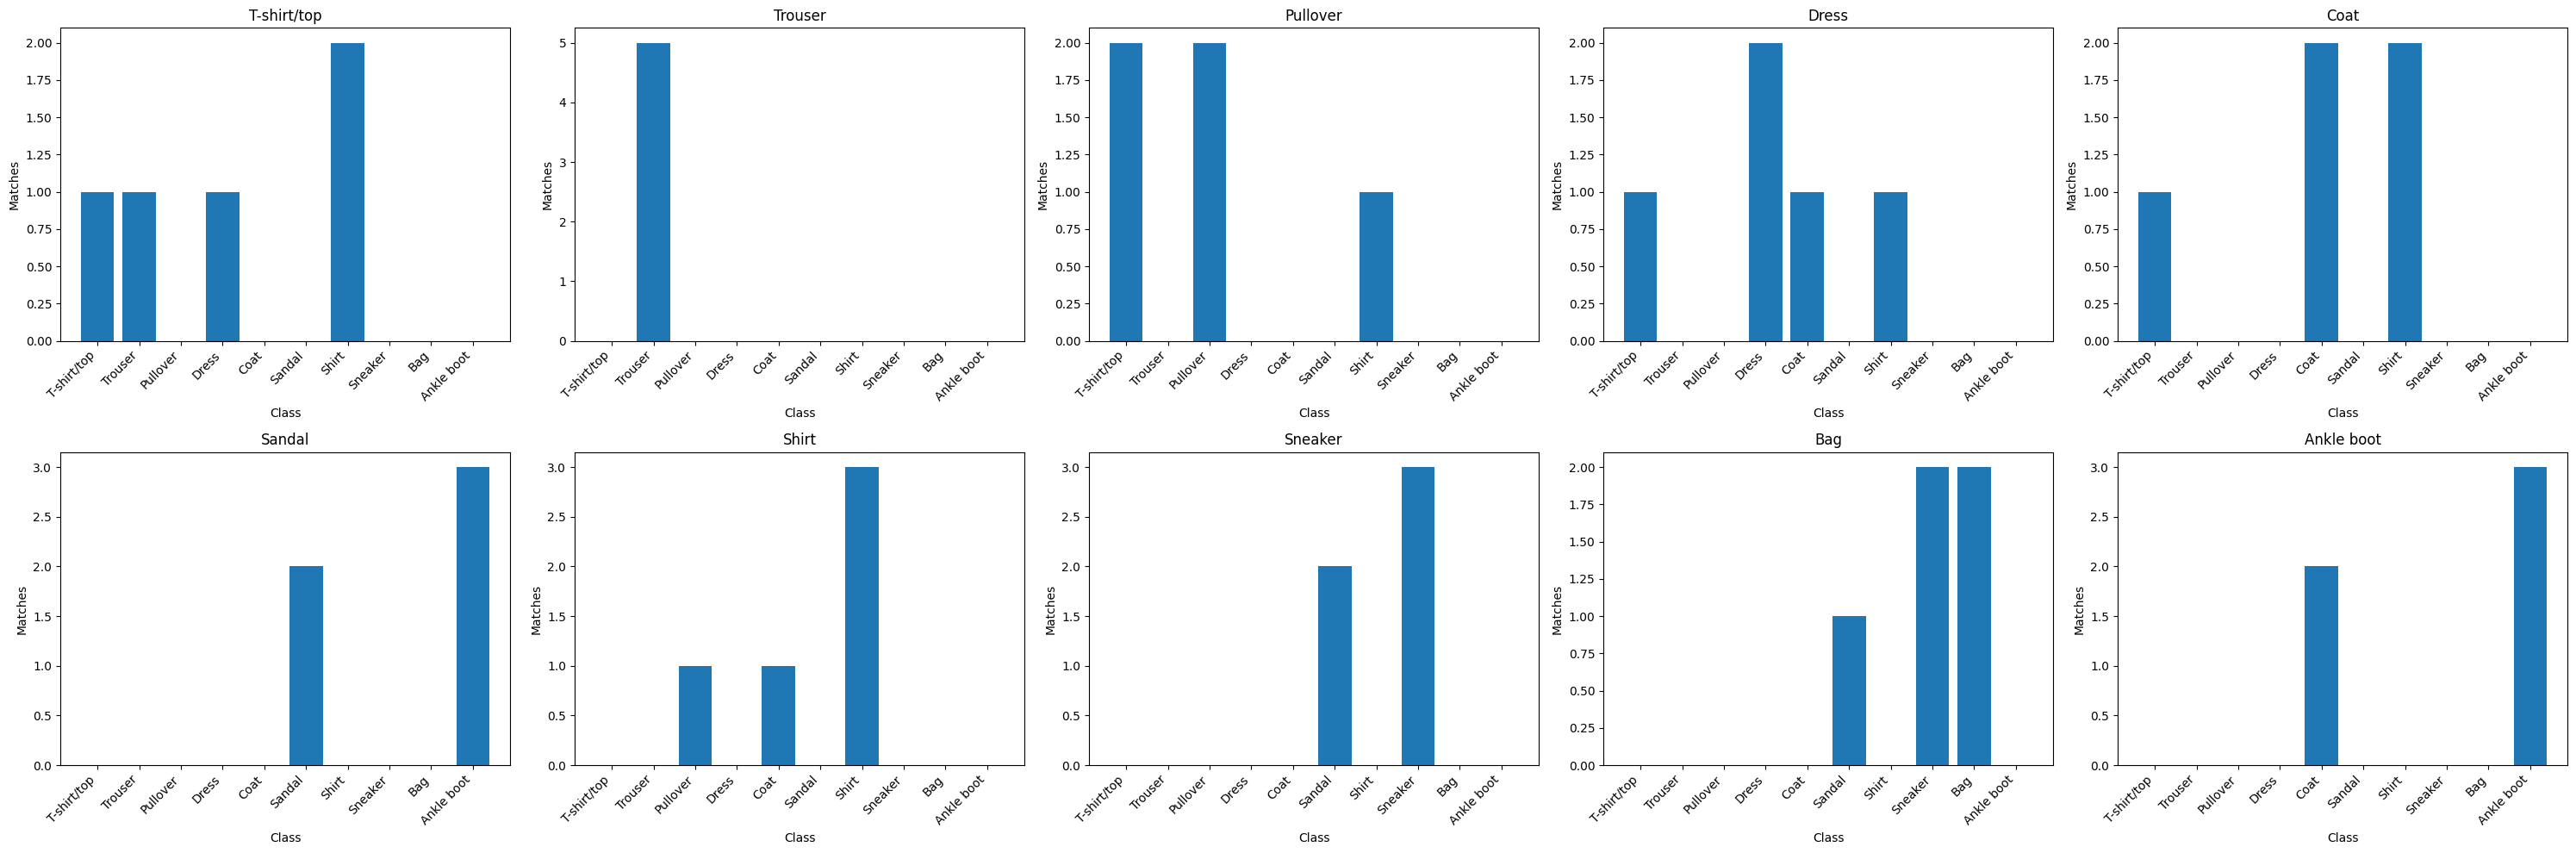

In [17]:
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(descriptors_np)

fig, axs = plt.subplots(2,5, figsize=(30, 10))

axs = axs.flatten()

for label in range(10):

    X = descriptors_np[y_train == label]
    idx = np.random.choice(X.shape[0], size=1, replace=False)
    query = X[idx]
    distances, indices = nbrs.kneighbors(query)
    name, occurance = np.unique(y_train[indices], return_counts=True)

    # create an array of zeros with the length of the total number of classes
    class_array = np.zeros(10)

    # assign the count values to their respective class indices
    for i in range(len(name)):
        class_array[name[i]] = occurance[i]
    axs[label].bar(label_names, class_array)
    for label_ in axs[label].get_xticklabels():
        label_.set_rotation(45)
        label_.set_ha('right')
    axs[label].set_xlabel('Class')
    axs[label].set_ylabel('Matches')
    axs[label].set_title(label_names[label])
plt.tight_layout()
plt.show()

#### Your implementation of the SIFT Descriptor

Implement the `generate_descriptors_from_patches` function to compute a (simplified) SIFT descriptor for each image in the dataset. This function is used to generate a very unique fingerprint for the patch. To do this, we look at a 16 x 16 windows around the keypoint (as the Fashion-MNIST data is 28 x 28, it is resized to 16 x 16). This 16 x 16 window is then broken into sixteen 4x4 windows. 

<center><img src="imgs/sift-fingerprint.jpg" alt="SIFT Fingerprint" width="960" /></center>

Within each 4x4 window, gradient magnitudes and orientations are calculated. These orientations are put into an 8 bin histogram. 

<center><img src="imgs/sift-4x4.jpg" alt="SIFT Gradients" width="960" /></center>

Orientation in the range 0-44 degrees add to the first bin, 45-89 add to the next bin and so on. The amount added to the bin depends on the magnitude of the gradient. Unlike as in the past, the amount added also depends on the distance from the keypoint. So gradients that are far away from the keypoint will add smaller values to the histogram.

This is done using a "gaussian weighting function". This function simply generates a gradient (it's like a 2D bell curve). You multiply it with the magnitude of orientations: The farther away, the lesser the magnutide. The sigma in the original paper is defined as one half of the width of the descriptor window. This weighting is put over the full patch with the keypoint (image patch center) as "origin" (see picture below, brown symbolizes the gaussian weighting function).

<center><img src="imgs/sift-g_weighting.jpg" alt="SIFT Gaussian Weighting" width="360" /></center>

In the end you should end up with 4x4x8 = 128 numbers. Once you have all 128 numbers, you normalize them (just like you would normalize a vector in school, divide by root of sum of squares). These 128 numbers form the "feature vector". This keypoint is uniquely identified by this feature vector.

This feature vector introduces a few complications. In the full version of SIFT you would get rid of them before finalizing the fingerprint.

- Rotation dependence: The feature vector uses gradient orientations. Clearly, if you rotate the image, everything changes. All gradient orientations also change. To achieve rotation independence, the keypoint's rotation is subtracted from each orientation. Thus each gradient orientation is relative to the keypoint's orientation.
- Illumination dependence: If we threshold numbers that are big, we can achieve achieve illumination independence. So, any number (of the 128) greater than 0.2 is changed to 0.2. This resultant feature vector is normalized again. And now you have an illumination independent feature vector!

In [ ]:
def compute_grad_mag_ori(patch):
    grad_mag, grad_ori = None, None
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    # Compute gradients using numpy
    Gx, Gy = np.gradient(patch)
    
    # Gradient magnitude: M = sqrt(Gx² + Gy²)
    grad_mag = np.sqrt(Gx**2 + Gy**2)
    
    # Gradient orientation: θ = atan2(Gy, Gx)
    # Convert from radians to degrees
    grad_ori = (np.arctan2(Gy, Gx)) * (180/np.pi)

    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    return grad_mag, grad_ori

def compute_histogram_of_gradients(grad_ori, weight, nbins):
    """Calculate the histogram of gradients"""
    
    hist = None
    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    hist = np.zeros(nbins)
    bin_width = 360.0 / nbins # 45 degrees per bin for nbins=8

    # Flatten the arrays to make them easy to loop over
    orientations = grad_ori.flatten()
    weights = weight.flatten()

    for ori, mag in zip(orientations, weights):
        # Determine which bin this orientation falls into
        bin_index = int(ori // bin_width)
        
        # Handle the case where orientation is exactly 360
        if bin_index >= nbins:
            bin_index = nbins - 1 
            
        # Add weighted contribution to histogram
        hist[bin_index] += mag
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    return hist

def generate_descriptors_from_patches(image_patch):
    """Generate descriptors for each patch"""
    # TODO: Set the window_width correctly
    window_width = 4 # Divide 16x16 patch into 4x4 windows
    desc = np.zeros((window_width*window_width*8,)) # 4*4*8 = 128 dimensions


    # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    # Compute gradients for the entire patch
    grad_mag, grad_ori = compute_grad_mag_ori(image_patch)

    desc_idx = 0
    # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****
    
    for i in range(0, 16, window_width):
        for j in range(0, 16, window_width):
            # *****BEGINNING OF YOUR CODE (DO NOT DELETE THIS LINE)*****
            # Extract the 4x4 Window
            mag_window = grad_mag[i:i+window_width, j:j+window_width]
            ori_window = grad_ori[i:i+window_width, j:j+window_width]
            
            # Compute histogram for this window
            hist = compute_histogram_of_gradients(ori_window, mag_window, nbins=8)
            
            # Add to descriptor
            desc[desc_idx:desc_idx+8] = hist
            desc_idx += 8
            # *****END OF YOUR CODE (DO NOT DELETE THIS LINE)*****

            
    desc /= (np.linalg.norm(desc) + 1e-60)
    desc[desc > 0.2] = 0.2
    desc /= (np.linalg.norm(desc) + 1e-60)
    return desc

imgs = X_train.reshape(k * len(classes), 28, 28)

descriptors = []

for img_id in range(k * len(classes)):
    img = imgs[img_id, :, :]
    des = generate_descriptors_from_patches(img)
    descriptors.append(des)

descriptors_np = np.array(descriptors)
print(descriptors_np.shape) #Should be (k * len(classes), 128)


(50, 128)


#### Visualization of your result

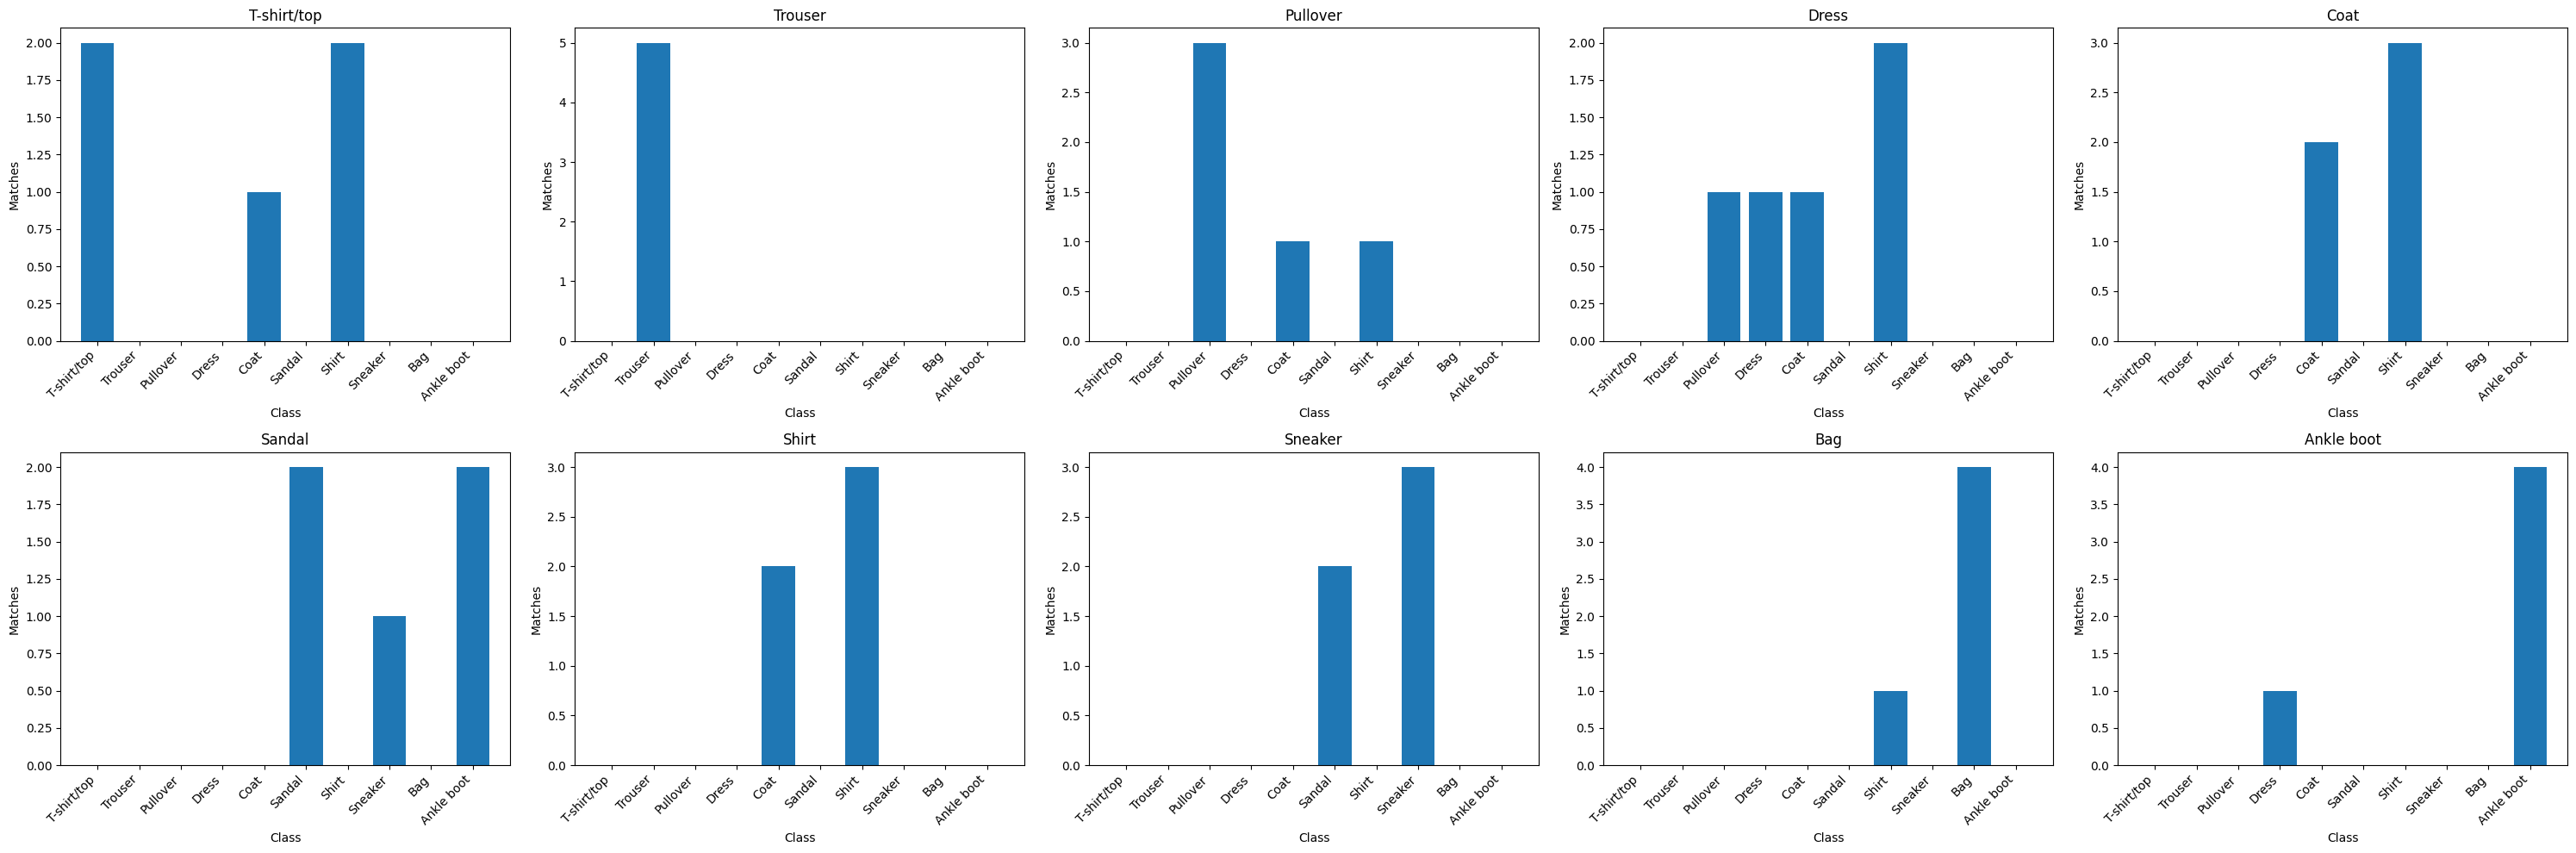

In [24]:
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(descriptors_np)

fig, axs = plt.subplots(2,5, figsize=(30, 10))

axs = axs.flatten()

for label in range(10):

    X = descriptors_np[y_train == label]
    idx = np.random.choice(X.shape[0], size=1, replace=False)
    query = X[idx]
    distances, indices = nbrs.kneighbors(query)
    name, occurance = np.unique(y_train[indices], return_counts=True)

    # create an array of zeros with the length of the total number of classes
    class_array = np.zeros(10)

    # assign the count values to their respective class indices
    for i in range(len(name)):
        class_array[name[i]] = occurance[i]
    axs[label].bar(label_names, class_array)
    for label_ in axs[label].get_xticklabels():
        label_.set_rotation(45)
        label_.set_ha('right')
    axs[label].set_xlabel('Class')
    axs[label].set_ylabel('Matches')
    axs[label].set_title(label_names[label])
plt.tight_layout()
plt.show()